# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('ATE_train.json', 'r'))
val_data = json.load(open('ATE_val.json', 'r'))
test_data = json.load(open('ATE_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2900, Accuracy: 0.9136, F1: 0.6109
Validation: Loss: 0.1745, Accuracy: 0.9418, F1: 0.7611
Epoch 2/10
Training: Loss: 0.1757, Accuracy: 0.9390, F1: 0.7746
Validation: Loss: 0.1615, Accuracy: 0.9463, F1: 0.7727
Epoch 3/10
Training: Loss: 0.1435, Accuracy: 0.9483, F1: 0.8117
Validation: Loss: 0.1622, Accuracy: 0.9451, F1: 0.7695
Epoch 4/10
Training: Loss: 0.1198, Accuracy: 0.9556, F1: 0.8421
Validation: Loss: 0.1609, Accuracy: 0.9480, F1: 0.7852
Epoch 5/10
Training: Loss: 0.0989, Accuracy: 0.9625, F1: 0.8706
Validation: Loss: 0.1666, Accuracy: 0.9468, F1: 0.7788
Epoch 6/10
Training: Loss: 0.0807, Accuracy: 0.9685, F1: 0.8954
Validation: Loss: 0.1736, Accuracy: 0.9459, F1: 0.7812
Epoch 7/10
Training: Loss: 0.0661, Accuracy: 0.9749, F1: 0.9173
Validation: Loss: 0.1778, Accuracy: 0.9466, F1: 0.7853
Epoch 8/10
Training: Loss: 0.0532, Accuracy: 0.9809, F1: 0.9393
Validation: Loss: 0.1795, Accuracy: 0.9473, F1: 0.7860
Epoch 9/10
Training: Loss: 0.0410, Accuracy: 0.9

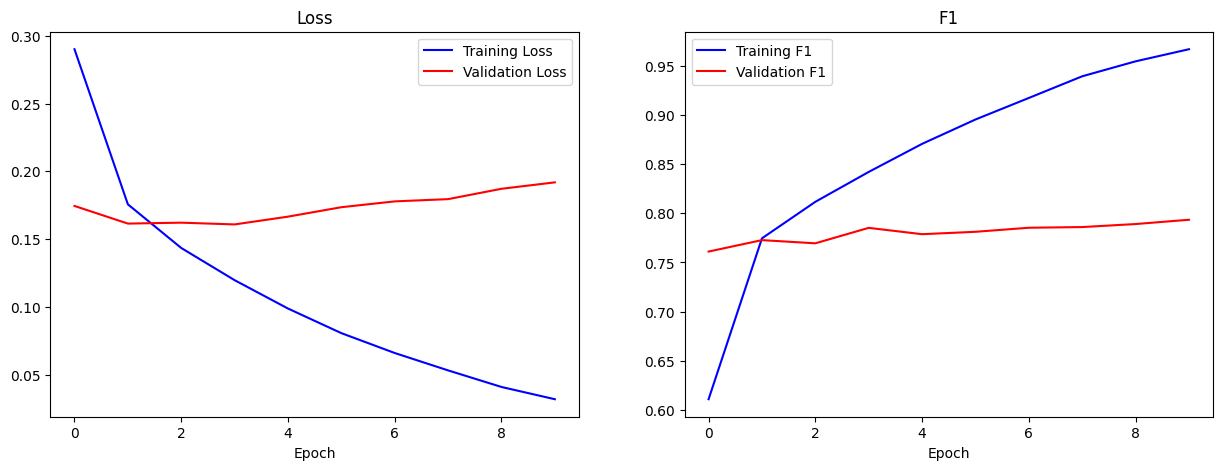

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
lstm_word2vec_model = lstm_word2vec_model.to('cpu')
torch.save(lstm_word2vec_model, "t2_model2_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t2_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2803504380475595, 1: 0.2380952380952381, 2: 0.3280627914912979}
Labelwise Accuracy Scores:
{0: 0.7257019438444925, 1: 0.5555555555555556, 2: 0.968868980963046}
LSTM with Word2Vec ==> Accuracy: 0.9277, F1: 0.7758


# For GloVe Embeddings

In [13]:
lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2962, Accuracy: 0.9126, F1: 0.5909
Validation: Loss: 0.2089, Accuracy: 0.9315, F1: 0.6738
Epoch 2/10
Training: Loss: 0.2062, Accuracy: 0.9343, F1: 0.7385
Validation: Loss: 0.1868, Accuracy: 0.9387, F1: 0.7216
Epoch 3/10
Training: Loss: 0.1691, Accuracy: 0.9432, F1: 0.7820
Validation: Loss: 0.1796, Accuracy: 0.9413, F1: 0.7414
Epoch 4/10
Training: Loss: 0.1411, Accuracy: 0.9530, F1: 0.8255
Validation: Loss: 0.1827, Accuracy: 0.9425, F1: 0.7501
Epoch 5/10
Training: Loss: 0.1191, Accuracy: 0.9596, F1: 0.8555
Validation: Loss: 0.1925, Accuracy: 0.9408, F1: 0.7406
Epoch 6/10
Training: Loss: 0.1018, Accuracy: 0.9658, F1: 0.8816
Validation: Loss: 0.2085, Accuracy: 0.9399, F1: 0.7327
Epoch 7/10
Training: Loss: 0.0896, Accuracy: 0.9704, F1: 0.8976
Validation: Loss: 0.2131, Accuracy: 0.9392, F1: 0.7368
Epoch 8/10
Training: Loss: 0.0791, Accuracy: 0.9749, F1: 0.9127
Validation: Loss: 0.2160, Accuracy: 0.9396, F1: 0.7481
Epoch 9/10
Training: Loss: 0.0734, Accuracy: 0.9

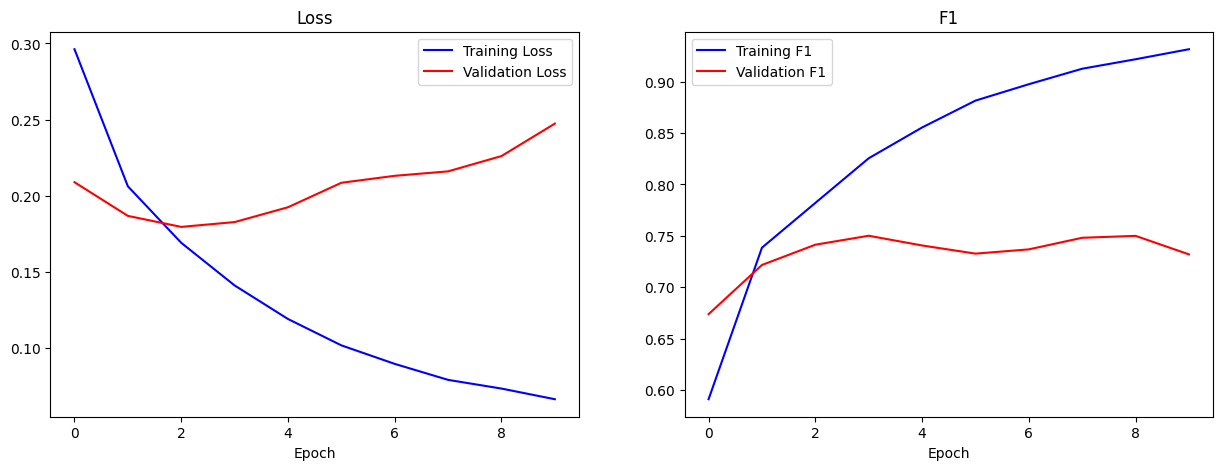

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
lstm_glove_model = lstm_glove_model.to('cpu')
torch.save(lstm_glove_model, "t2_model2_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t2_model2_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.23616922361692239, 1: 0.18737672583826429, 2: 0.3302060962284767}
Labelwise Accuracy Scores:
{0: 0.5485961123110151, 1: 0.39094650205761317, 2: 0.9814109742441209}
LSTM with GloVe ==> Accuracy: 0.9149, F1: 0.7022


# For FastText Embeddings

In [18]:
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.3225, Accuracy: 0.8979, F1: 0.5223
Validation: Loss: 0.1886, Accuracy: 0.9315, F1: 0.6755
Epoch 2/10
Training: Loss: 0.1896, Accuracy: 0.9319, F1: 0.7412
Validation: Loss: 0.1655, Accuracy: 0.9420, F1: 0.7402
Epoch 3/10
Training: Loss: 0.1628, Accuracy: 0.9400, F1: 0.7792
Validation: Loss: 0.1552, Accuracy: 0.9449, F1: 0.7624
Epoch 4/10
Training: Loss: 0.1460, Accuracy: 0.9443, F1: 0.7984
Validation: Loss: 0.1494, Accuracy: 0.9442, F1: 0.7625
Epoch 5/10
Training: Loss: 0.1324, Accuracy: 0.9496, F1: 0.8196
Validation: Loss: 0.1473, Accuracy: 0.9468, F1: 0.7719
Epoch 6/10
Training: Loss: 0.1193, Accuracy: 0.9529, F1: 0.8329
Validation: Loss: 0.1487, Accuracy: 0.9471, F1: 0.7766
Epoch 7/10
Training: Loss: 0.1064, Accuracy: 0.9583, F1: 0.8559
Validation: Loss: 0.1515, Accuracy: 0.9461, F1: 0.7732
Epoch 8/10
Training: Loss: 0.0940, Accuracy: 0.9624, F1: 0.8722
Validation: Loss: 0.1549, Accuracy: 0.9466, F1: 0.7778
Epoch 9/10
Training: Loss: 0.0818, Accuracy: 0.9

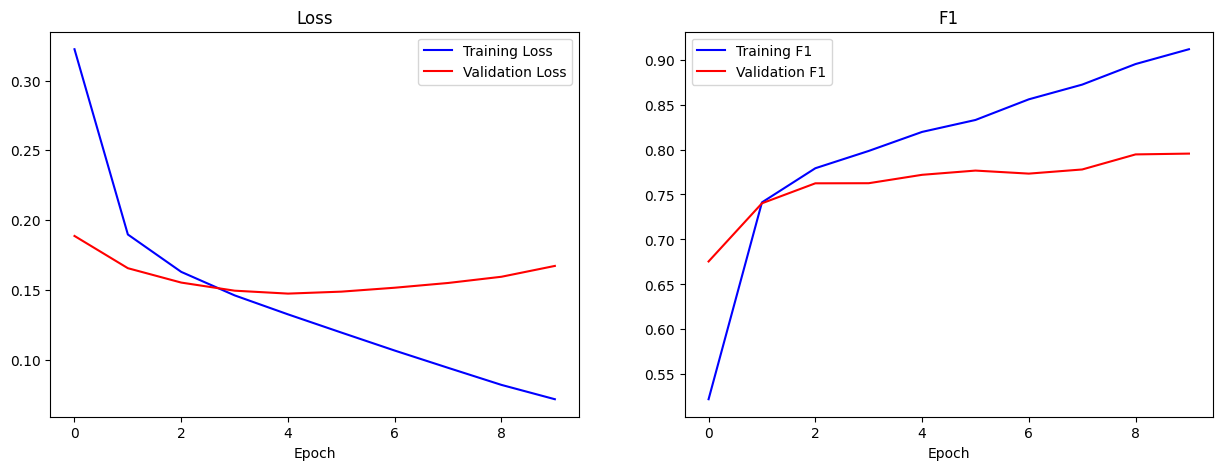

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
lstm_fasttext_model = lstm_fasttext_model.to('cpu')
torch.save(lstm_fasttext_model, "t2_model2_fasttext.pt")

In [23]:
test_accuracy, test_f1 = test("t2_model2_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2803504380475595, 1: 0.22644927536231885, 2: 0.3278700963654298}
Labelwise Accuracy Scores:
{0: 0.7257019438444925, 1: 0.51440329218107, 2: 0.9677491601343785}
LSTM with FastText ==> Accuracy: 0.9248, F1: 0.7636
